# 数字图像+180776+胡欣毅(Python版)
# 7周上课随堂测验

题目清单（100/100）
1. 拍一张照片（具有清晰易检测边缘），压缩为255 * 255 大小。对照片进行2 * 2 max_pooling操作，滑动间隔为1 （30/100）

2. 对该照片进行laplace边缘检测（40/100）

3. 对该照片进行laplace图像增强（30/100）

注：
1. 本次实验不可调opencv库

2. 本次实验根据完成程度和完成速度评分，分数可能计入总评

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

(256, 256)

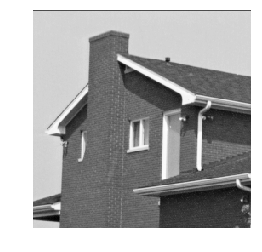

In [3]:
im = cv2.imread('../data/4.1.05.tiff')

gray = rgb2gray(im)
plt.imshow(gray,cmap='gray')
plt.axis("off")
gray.shape

In [4]:
def pooling(image , poolSize = 2 , poolStride = 2 , mode = 'max' ):  
    # image sizes
    in_row,in_col = np.shape(image)
    
    # outputMap sizes
    out_row,out_col = int(np.ceil( (in_row - poolSize)/poolStride +1 )),\
                      int(np.ceil( (in_col - poolSize)/poolStride +1 ))
    outputMap = np.zeros((out_row,out_col))
    
    # 补 0 padding
    temp_map = np.pad(image, ((0,in_row%poolStride),(0,in_col%poolStride)),'edge')
    
    # pooling
    for r_idx in range(out_row):
        for c_idx in range(out_col):
            startY = r_idx * poolStride
            startX = c_idx * poolStride
            poolField = temp_map[startY:startY + poolSize, startX:startX + poolSize]
            if mode == 'max':
                poolOut = np.max(poolField)
            elif mode == 'mean':
                poolOut = np.mean(poolField)
                
            outputMap[r_idx,c_idx] = poolOut
    return  outputMap

# 测试实例
test = np.array([[1,2,3,4],
                 [5,6,7,8],
                 [9,10,11,12],
                 [13,14,15,16]])

test_result = pooling(test, 2, 2, 'max')
print(test_result)

[[ 6.  8.]
 [14. 16.]]


In [5]:
def my_filter2D( img , kel ):
    m,n = kel.shape
    # out 是输出
    out = np.zeros(img.shape)
    # mat 是补完 0 的
    mat = np.zeros( (img.shape[0]+m-1, img.shape[1]+n-1) )
    # 扩充
    #mat = np.pad(img, ((m-1,0),(n-1,0)),'constant')
    mat[(m-1):,(n-1):] = img
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j] = np.multiply(mat[i:i+m,j:j+n] , kel ).sum()    
    return out

# 测试 2 维卷积
my_filter2D(np.ones((3,3)),np.ones((2,2)) )

array([[1., 2., 2.],
       [2., 4., 4.],
       [2., 4., 4.]])

In [6]:
def my_resize(src, size,mode = 'INTER_LINEAR'):
    dst_width, dst_height = size
    
    if len(src.shape) == 3:
        height, width, channels = src.shape
        if ((dst_height == height) and (dst_width == width)):
            return src
        dst_image = np.zeros((dst_height, dst_width, channels) )

        # Scale for resize.
        scale_x = float(width) /dst_width
        scale_y = float(height)/dst_height
        # tmp
        if mode == "INTER_LINEAR":
            for dst_y in range(dst_height):
                for dst_x in range(dst_width):
                    # Original coords.
                    src_x = (dst_x + 0.5) * scale_x - 0.5
                    src_y = (dst_y + 0.5) * scale_y - 0.5
                    # INTER_LINEAR: 
                    # 2*2 neighbors.(对角线两个值)
                    src_x_0 = int(np.floor(src_x))
                    src_y_0 = int(np.floor(src_y))
                    src_x_1 = min(src_x_0 + 1, width - 1)
                    src_y_1 = min(src_y_0 + 1, height - 1)
                    # 插值(左上，右上，右下，左下，顺时针)
                    dst_image[dst_y, dst_x,:] = \
                    (src_y_1 - src_y) *  (src_x_1 - src_x) * src[src_y_0, src_x_0,:]\
                    + (src_y_1 - src_y) * (src_x - src_x_0) * src[src_y_0, src_x_1,:]\
                    + (src_y - src_y_0) * (src_x - src_x_0) * src[src_y_1, src_x_1,:]\
                    + (src_y - src_y_0) * (src_x_1 - src_x) * src[src_y_1, src_x_0,:]
        elif mode == 'nearby':
            for dst_y in range(dst_height):
                for dst_x in range(dst_width):
                    # Original coords.
                    src_x = (dst_x + 0.5) * scale_x - 0.5
                    src_y = (dst_y + 0.5) * scale_y - 0.5 
                    dst_image[dst_y, dst_x,:] = src[int(src_y), int(src_x),:]
        return dst_image
    
    elif len(src.shape) == 2:
        height, width = src.shape
        if ((dst_height == height) and (dst_width == width)):
            return src
        dst_image = np.zeros((dst_height, dst_width) )
        
        # Scale for resize.
        scale_x = float(width) /dst_width
        scale_y = float(height)/dst_height
        # tmp
        if mode == "INTER_LINEAR":
            for dst_y in range(dst_height):
                for dst_x in range(dst_width):
                    # Original coords.
                    src_x = (dst_x + 0.5) * scale_x - 0.5
                    src_y = (dst_y + 0.5) * scale_y - 0.5
                    # INTER_LINEAR: 
                    # 2*2 neighbors.(对角线两个值)
                    src_x_0 = int(np.floor(src_x))
                    src_y_0 = int(np.floor(src_y))
                    src_x_1 = min(src_x_0 + 1, width - 1)
                    src_y_1 = min(src_y_0 + 1, height - 1)
                    # 插值(左上，右上，右下，左下，顺时针)
                    dst_image[dst_y, dst_x] = \
                    (src_y_1 - src_y) *  (src_x_1 - src_x) * src[src_y_0, src_x_0]\
                    + (src_y_1 - src_y) * (src_x - src_x_0) * src[src_y_0, src_x_1]\
                    + (src_y - src_y_0) * (src_x - src_x_0) * src[src_y_1, src_x_1]\
                    + (src_y - src_y_0) * (src_x_1 - src_x) * src[src_y_1, src_x_0]
        elif mode == 'nearby':
            for dst_y in range(dst_height):
                for dst_x in range(dst_width):
                    # Original coords.
                    src_x = (dst_x + 0.5) * scale_x - 0.5
                    src_y = (dst_y + 0.5) * scale_y - 0.5 
                    dst_image[dst_y, dst_x] = src[int(src_y), int(src_x)]
        return dst_image

# 测试 resize 
my_resize(np.arange(16).reshape(4,4),(2,2) )

array([[ 2.5,  4.5],
       [10.5, 12.5]])

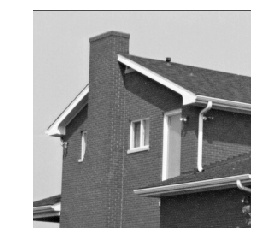

In [7]:
dst_size = (255,255)
dst = my_resize(gray, dst_size,'nearby')
plt.imshow(dst,cmap='gray')
plt.axis("off")
plt.show()

In [8]:
pool_image = pooling(dst , poolSize = 2 , poolStride = 1 , mode = 'max' )

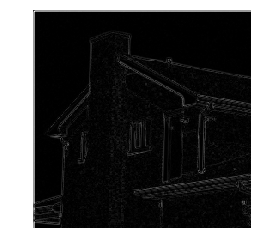

(254, 254)

In [9]:
Laplace_ker = np.array([[1, 1, 1],
                       [1,-8, 1],
                       [1, 1, 1]])

lapace = my_filter2D(pool_image , Laplace_ker)
#cv2.normalize(lapace, lapace,0,1,cv2.NORM_MINMAX) 
plt.imshow(abs(lapace), cmap='gray')
plt.axis("off")
plt.show()
lapace.shape

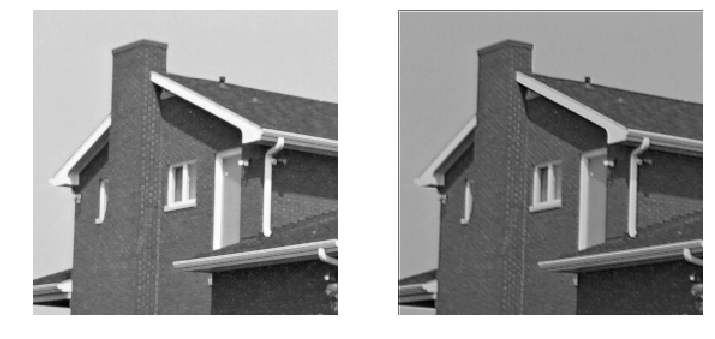

In [10]:
labd = 0.1
re_build = pool_image - labd  * lapace

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(pool_image,cmap='gray')
plt.axis("off")
plt.subplot(122)
plt.imshow(re_build,cmap='gray')
plt.axis("off")
plt.show()

# 图像处理+180776+胡欣毅(C++版)

[c++](c++/hxy.cpp)